In [36]:

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import caffe
from skimage.metrics import(
    peak_signal_noise_ratio as psnr,
    structural_similarity as ssim,
)
from PIL import Image

In [37]:
def pad_image(img: np.ndarray, new_height: int, new_width: int):

    padding = np.zeros((new_height, new_width))
    img_height, img_width = img.shape
    padding[:img_height, :img_width] = img
    return padding

In [38]:
idx=2
base='/mnt/data_drive/hrodrigo/mri_rician_noise/deep-image-prior/.brainweb_test_data'
noisy_orig=np.load(f'{base}/im_{idx}/Std0.15.npy')
gt_orig=np.load(f'{base}/im_{idx}/gt.npy')

gt = pad_image(gt_orig[0], 256, 270)
noisy = pad_image(noisy_orig[0], 256, 270)

(array([2.413e+03, 6.269e+03, 8.627e+03, 8.696e+03, 7.614e+03, 6.039e+03,
        4.472e+03, 3.367e+03, 3.003e+03, 2.642e+03, 2.537e+03, 2.363e+03,
        2.132e+03, 1.727e+03, 1.293e+03, 9.490e+02, 6.340e+02, 3.790e+02,
        2.000e+02, 1.020e+02, 5.100e+01, 1.500e+01, 8.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([4.70552128e-04, 5.09700663e-02, 1.01469584e-01, 1.51969105e-01,
        2.02468619e-01, 2.52968132e-01, 3.03467661e-01, 3.53967160e-01,
        4.04466689e-01, 4.54966187e-01, 5.05465686e-01, 5.55965245e-01,
        6.06464744e-01, 6.56964242e-01, 7.07463801e-01, 7.57963300e-01,
        8.08462799e-01, 8.58962297e-01, 9.09461856e-01, 9.59961355e-01,
        1.01046085e+00, 1.06096041e+00, 1.11145985e+00, 1.16195941e+00,
        1.21245897e+00, 1.26295841e+00, 1.31345797e+00], dtype=float32),
 <BarContainer object of 26 artists>)

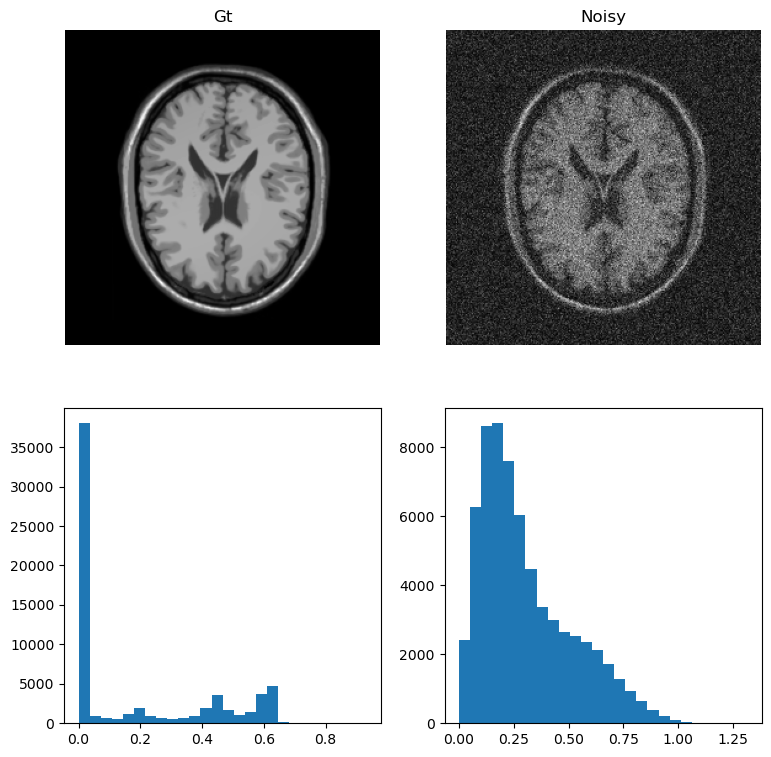

In [39]:
plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.imshow(gt_orig[0],cmap='gray')
plt.title('Gt')
plt.axis(False)
plt.subplot(2,2,2)
plt.imshow(noisy_orig[0], cmap='gray')
plt.title('Noisy')
plt.axis(False)
plt.subplot(2,2,3)
plt.hist(gt_orig[:256,:256].flatten(),bins=26)
plt.subplot(2,2,4)
plt.hist(noisy_orig[:256,:256].flatten(),bins=26)

In [40]:
prototext_path = "/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/Riciannet_deploy.prototxt"
weights_path = "/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/model/N15_complex_Brain1&2.caffemodel"


caffe.set_mode_cpu()  # Use caffe.set_mode_gpu() if you want to use GPU



In [41]:
net = caffe.Net(prototext_path, weights_path, caffe.TEST)
result = net.forward(data=noisy[None, None, ...])

W0129 19:46:51.711308 52275 _caffe.cpp:139] DEPRECATION WARNING - deprecated use of Python interface
W0129 19:46:51.711323 52275 _caffe.cpp:140] Use this instead (with the named "weights" parameter):
W0129 19:46:51.711326 52275 _caffe.cpp:142] Net('/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/Riciannet_deploy.prototxt', 1, weights='/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/model/N15_complex_Brain1&2.caffemodel')
I0129 19:46:51.712034 52275 upgrade_proto.cpp:67] Attempting to upgrade input file specified using deprecated input fields: /mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/Riciannet_deploy.prototxt
I0129 19:46:51.712046 52275 upgrade_proto.cpp:70] Successfully upgraded file specified using deprecated input fields.
W0129 19:46:51.712049 52275 upgrade_proto.cpp:72] Note that future Caffe releases will only support input layers and not input fields.
I0129 19:46:51.712052 52275 upgrade_proto.cpp:77] Attempting to upgrade batch n

In [42]:
result_conv13 = result["conv13"].squeeze()#.clip(0., 1.)

In [43]:
mask_path='/mnt/data_drive/hrodrigo/mri_rician_noise/deep-image-prior/.brainweb_test_data/im_7/mask.png'

mask = np.array(Image.open(mask_path).convert("L")).T
mask = mask / mask.max()
print(mask.min(),mask.max())



0.0 1.0


In [44]:
def psnr_with_mask(
    img_1: np.ndarray,
    img_2: np.ndarray,
    mask: np.ndarray,
    data_range=1.0,
):
    mask_size = (mask > 0).sum().item()
    mse = ((img_1 - img_2) ** 2 * mask).sum() / mask_size
    return 10 * np.log10(data_range**2 / mse)

In [45]:
maskless_psnr = psnr(
        result_conv13[:256, :256],
        gt[:256,:256],
        data_range=1.0,
    )
mask_psnr = psnr_with_mask(
        result_conv13[:256, :256],
        gt[:256, :256],
        mask
    )

print('--- PSNR values ---')
print(f'with mask: {mask_psnr}')
print(f'without mask: {maskless_psnr}')


--- PSNR values ---
with mask: 25.584489924014644
without mask: 27.80364167351531


Plotsies!

(-0.5, 255.5, 255.5, -0.5)

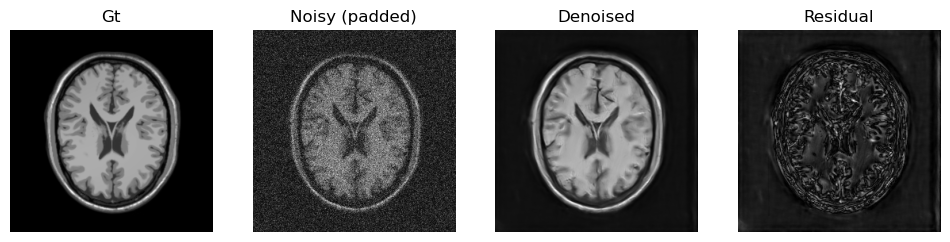

In [46]:
plt.figure(figsize=(12,6))
n_plots=4
plt.subplot(1,n_plots,1)
plt.imshow(gt_orig[0],cmap='gray')
plt.title('Gt')
plt.axis(False)
plt.subplot(1,n_plots,2)
plt.imshow(noisy_orig[0], cmap='gray')
plt.title('Noisy (padded)')
plt.axis(False)
plt.subplot(1,n_plots,3)
plt.imshow(result_conv13[:256,:256],cmap='gray')
plt.title('Denoised')
plt.axis(False)
plt.subplot(1,n_plots,4)
plt.imshow(np.abs(result_conv13[:256,:256] - gt_orig[0]),cmap='gray')
plt.title('Residual')
plt.axis(False)

(-0.5, 255.5, 255.5, -0.5)

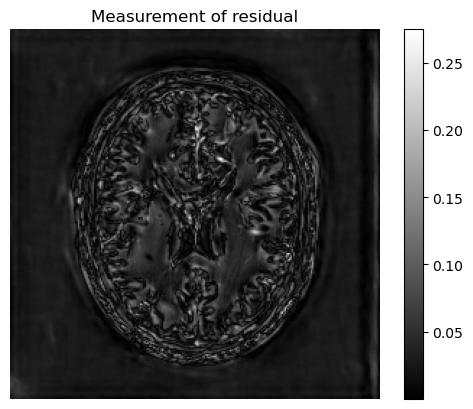

In [47]:
plt.imshow(np.abs(result_conv13[:256, :256] - gt[:256,:256]),cmap='gray')
plt.colorbar()
plt.title('Measurement of residual')
plt.axis(False)

SSIM value is 0.49406598020697223


(-0.5, 255.5, 255.5, -0.5)

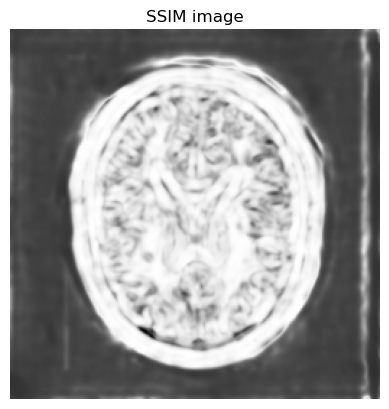

In [48]:
idx, img = ssim(gt[:256,:256],result_conv13[:256, :256], data_range=gt.max()-gt.min(), full=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
print(f'SSIM value is {idx}')
plt.imshow(img, cmap='gray')
plt.title('SSIM image')
plt.axis(False)